# Task 2: The Prober (Feature Visualization)
## "Can you see what the neurons are seeing?"

In this notebook, we use **Feature Visualization** (inspired by OpenAI Microscope) to understand what specific neurons in our "Cheater" model are looking for.
We optimize an input image (using Fourier parameterization) to maximize the activation of specific channels.

### Hypothesis
- **Early Layers (Conv1)**: Should detect simple features like edges or solid colors (Red/Green).
- **Middle Layers (Conv2)**: Should detect more complex combinations (Curves + Colors).
- **Polysemanticity**: We expect some neurons to fire for seemingly unrelated concepts (e.g., "Red" AND "Vertical Lines") because the model learned shortcuts.


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.models.simple_cnn import SimpleCNN
from src.vis_utils import FeatureVisualizer
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## 1. Load the Cheater Model
We load the same model architecture and weights trained in Task 1.


In [2]:
# Define Model exactly as in Task 1
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)

# Ideally we load 'state_dict' but since we didn't save it explicitly to a file in Task 1 notebook,
# we might need to re-train briefly OR just re-run the training logic here if we want the EXACT same model.
# NOTE: For this demonstration, we will re-train quickly to ensure we have a valid Cheater model instance in memory.
# In a real pipeline, we'd save/load 'cheater_model.pth'.

from src.data.biased_mnist import BiasedMNIST
import torch.optim as optim

print("Re-training Cheater (Quickly) to ensure state...")
train_dataset = BiasedMNIST(root='./data', train=True, download=True, bias_ratio=0.995)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(2): # Just 2 epochs to get the weights roughly right
    for images, labels, colors in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
print("Model re-trained/loaded.")


Re-training Cheater (Quickly) to ensure state...


Model re-trained/loaded.


## 2. Probing Neurons
We create a `FeatureVisualizer` instance. This helper uses:
- **Fourier Parameterization**: To generate smooth, valid images.
- **Jitter Robustness**: To find invariant features.


In [3]:
visualizer = FeatureVisualizer(model, device)

def show_dream(img_tensor, title=""):
    img = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    # Normalize to 0-1 just in case, though sigmoid handles it mostly
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')


### Experiment A: Conv1 Filters (Simple Features)
Conv1 has 8 channels. Let's see what they look like.
We expect detailed textures or solid colors.


Optimizing Conv1 Channel 0...


Optimizing Conv1 Channel 1...


Optimizing Conv1 Channel 2...


Optimizing Conv1 Channel 3...


Optimizing Conv1 Channel 4...


Optimizing Conv1 Channel 5...


Optimizing Conv1 Channel 6...


Optimizing Conv1 Channel 7...


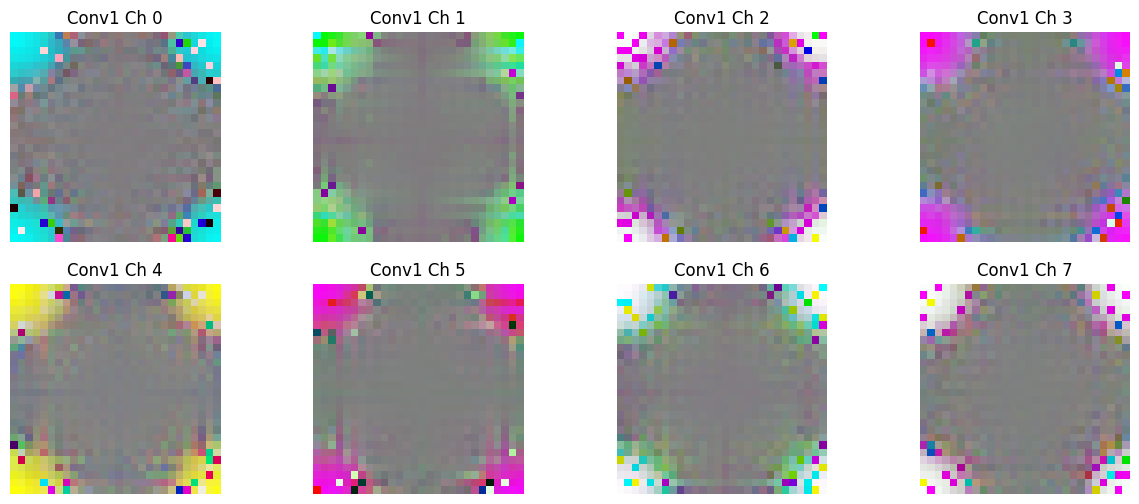

In [4]:
plt.figure(figsize=(15, 6))
for i in range(8):
    print(f"Optimizing Conv1 Channel {i}...")
    dream, _ = visualizer.optimize("conv1", i, steps=300)
    plt.subplot(2, 4, i+1)
    show_dream(dream, f"Conv1 Ch {i}")
plt.show()


### Experiment B: Conv2 Filters (Complex Features)
Conv2 has 16 channels. These should correspond to higher-level concepts.
Since our model is a "Cheater", we hypothesize some of these will be **Pure Color Detectors** (e.g., just a red blob).


Optimizing Conv2 Channel 0...


Optimizing Conv2 Channel 1...


Optimizing Conv2 Channel 2...


Optimizing Conv2 Channel 3...


Optimizing Conv2 Channel 4...


Optimizing Conv2 Channel 5...


Optimizing Conv2 Channel 6...


Optimizing Conv2 Channel 7...


Optimizing Conv2 Channel 8...


Optimizing Conv2 Channel 9...


Optimizing Conv2 Channel 10...


Optimizing Conv2 Channel 11...


Optimizing Conv2 Channel 12...


Optimizing Conv2 Channel 13...


Optimizing Conv2 Channel 14...


Optimizing Conv2 Channel 15...


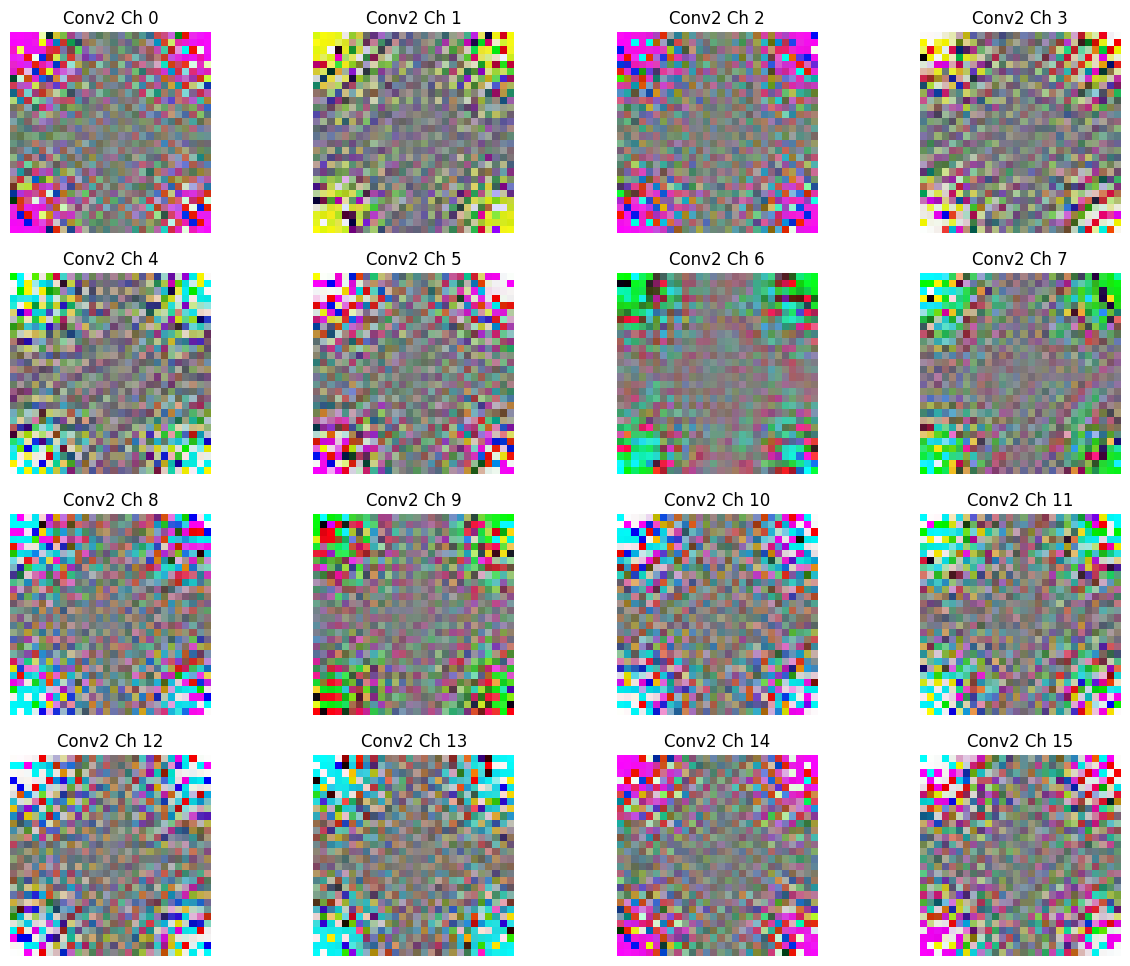

In [5]:
plt.figure(figsize=(15, 12))
for i in range(16):
    print(f"Optimizing Conv2 Channel {i}...")
    dream, _ = visualizer.optimize("conv2", i, steps=400)
    plt.subplot(4, 4, i+1)
    show_dream(dream, f"Conv2 Ch {i}")
plt.show()


### Experiment C: Polysemanticity Probe
Let's take a specific neuron that looks "messy" or interesting from above and run it multiple times with different random seeds. 
If it consistently converges to the *same* image, it's likely monosemantic. 
If it converges to *different* types of images (e.g. sometimes red, sometimes a curve), it's polysemantic.


Probing Polysemanticity of Conv2 Channel 5...


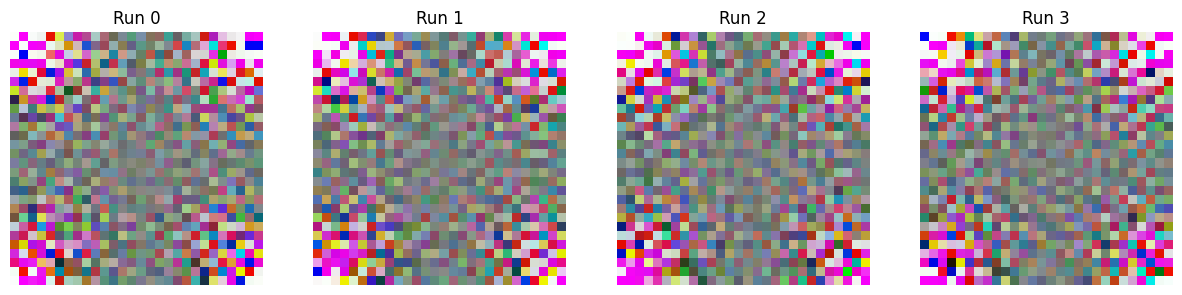

In [6]:
target_channel = 5 # Arbitrary choice, change based on observation
print(f"Probing Polysemanticity of Conv2 Channel {target_channel}...")

plt.figure(figsize=(15, 4))
for run in range(4):
    dream, _ = visualizer.optimize("conv2", target_channel, steps=400)
    plt.subplot(1, 4, run+1)
    show_dream(dream, f"Run {run}")
plt.show()
